In [ ]:
"""
This notebook generates figures 7 and 9
Figure 7 is generated by reading the simulated and observed hailstone maximum dimensions and plotting their distribution
Figure 9 is generated using the final properties of the simulated stones
"""

In [15]:
import os
from glob import glob
import warnings
import json
import math

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import netCDF4 as nc

In [16]:
final_nc_ffn = '/home/meso/Insync/onedrive/sync/papers/hail-xsec_paper/hgtm-output/hgtm_finalsizes.nc'
diameter_nc_ffn = '/home/meso/Insync/onedrive/sync/papers/hail-xsec_paper/hgtm-output/hgtm_growth_timeseries.nc'
regime_nc_ffn = '/home/meso/Insync/onedrive/sync/papers/hail-xsec_paper/hgtm-output/hgtm_growth_regime.nc'

In [17]:
#read simulated hail data (final properties)
with nc.Dataset(final_nc_ffn) as ncid:
    hgtm_size = ncid['dfinal'][:][0]
hgtm_id = np.arange(1, len(hgtm_size)+1)

#read timeseries datasets
with nc.Dataset(diameter_nc_ffn) as ncid:
    diameters = ncid['GROWTH_TIMESERIES_ALL'][:] #diameters (in mm)
with nc.Dataset(regime_nc_ffn) as ncid:
    regimes = ncid['GROWTH_REGIME_ALL'][:] #regime, where 1 is wet growth and 0 is dry growth

In [60]:
#calculate total wet growth fraction and final wet growth layer fraction
n_hail = np.shape(diameters)[1]
wet_growth_area_perc = []
final_wet_growth_area_perc = []
for hail_idx in range(n_hail):
    #extract dataset
    hail_radius_ts = diameters[:,hail_idx]/2
    hail_regime_ts = regimes[:,hail_idx]
    nan_mask = np.isnan(hail_radius_ts)
    hail_radius_ts = hail_radius_ts[~nan_mask]
    hail_regime_ts = hail_regime_ts[~nan_mask]
    #init
    wet_growth_area = 0
    final_wet_growth_area = 0
    last_area = 0
    #loop to find wet growth area and final layer
    for idx, radius in enumerate(hail_radius_ts):
        if idx == len(hail_radius_ts)-1:
            #the last growth timestep is always assigned -1, skip this one
            pass
        elif hail_regime_ts[idx] == 1:
            #use the last area to calculate the new wet growth
            wet_growth_area += (math.pi * radius**2) - last_area
            final_wet_growth_area += (math.pi * radius**2) - last_area
        else:
            #dry growth has occured, reset the final wet growth area
            final_wet_growth_area = 0
        last_area = math.pi * radius**2
    #final area
    final_area = math.pi * (hgtm_size[hail_idx]/2)**2
    wet_growth_area_perc.append(wet_growth_area/final_area)
    final_wet_growth_area_perc.append(final_wet_growth_area/final_area)


In [61]:
#read observed hail measurements
obs_csv = '/home/meso/Insync/onedrive/sync/papers/hail-xsec_paper/obs-output/obs_measurements.csv'
obs_df = pd.read_csv(obs_csv)
obs_size = obs_df['oblate_spheroid_dmax_dmin_Deq_mm']
obs_id = obs_df['id']

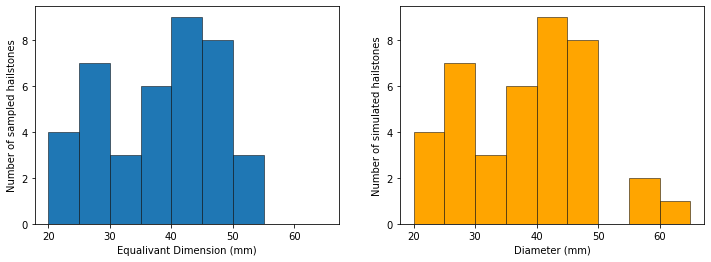

In [65]:
#create histogram plot of hail size distribution from HGTM and observed
fig = plt.figure(figsize=[12,4], facecolor='w')
plt.subplot(121)
plt.hist(obs_size, bins=[20,25,30,35,40,45,50,55,60,65], edgecolor='black', linewidth=0.5)
plt.ylabel('Number of sampled hailstones')
plt.xlabel('Equalivant Dimension (mm)')

plt.subplot(122)
plt.hist(hgtm_size, bins=[20,25,30,35,40,45,50,55,60,65], color='orange', edgecolor='black', linewidth=0.5)
plt.ylabel('Number of simulated hailstones')
plt.xlabel('Diameter (mm)')

plt.savefig('fig07.png', dpi=150)

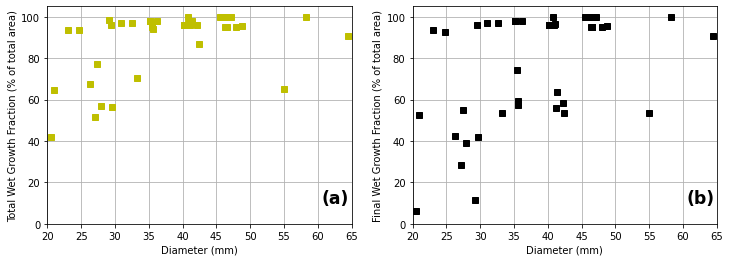

In [66]:
#create figure show growth properties of HGTM stones

fig = plt.figure(figsize=[12,4], facecolor='w')

plt.subplot(121)
plt.plot(hgtm_size, 100*np.array(wet_growth_area_perc), 'ys')
plt.xlabel('Diameter (mm)')
plt.ylabel('Total Wet Growth Fraction (% of total area)')
plt.xlim([20, 65])
plt.ylim([0, 105])
plt.grid()
plt.text(60.5, 10, '(a)', size='xx-large', weight='bold')

plt.subplot(122)
plt.plot(hgtm_size, 100*np.array(final_wet_growth_area_perc), 'ks')
plt.xlabel('Diameter (mm)')
plt.ylabel('Final Wet Growth Fraction (% of total area)')
plt.xlim([20,65])
plt.ylim([0, 105])
plt.text(60.5, 10, '(b)', size='xx-large', weight='bold')
plt.grid()

plt.savefig('fig08.png', dpi=150)

In [68]:
print(np.mean(wet_growth_area_perc))

0.8839319911416185
